# Install Transformers Library

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 19.3MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
     |████████████████████████████████| 3.2MB 46.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=025c12ad0f55f04416dd76a7a926f31b1209de0ad110758414e52575d4102168
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving labeled_17k.txt to labeled_17k.txt


In [ ]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['labeled_10k.txt']))

In [ ]:
df = pd.read_csv("labeled_10k.txt")
df.head()

,hmid,moment,concepts,agency,social,age,country,gender,married,parenthood,reflection,duration
0,27674,I was happy when my son got 90% marks in his e...,education|family,no,yes,29.0,IND,m,married,y,24h,half_a_day
1,27685,went to movies with my friends it was fun,entertainment,yes,yes,29.0,IND,m,single,y,24h,half_a_day
2,27691,A hot kiss with my girl friend last night made...,romance,yes,yes,25.0,IND,m,married,y,24h,at_least_one_hour
3,27701,My son woke me up to a fantastic breakfast of ...,family|food,no,yes,79,USA,f,widowed,y,24h,all_day_im_still_feeling_it
4,27712,My older daughter keeps patting my younger dau...,family,no,yes,30,USA,f,married,y,24h,a_few_moment


In [ ]:
df = df[['moment', 'agency', 'social']]
df['agency'] = df['agency'].map(
                   {'yes':1 ,'no':0})
df['social'] = df['social'].map(
                   {'yes':1 ,'no':0})
df.head()

,moment,agency,social
0,I was happy when my son got 90% marks in his e...,0,1
1,went to movies with my friends it was fun,1,1
2,A hot kiss with my girl friend last night made...,1,1
3,My son woke me up to a fantastic breakfast of ...,0,1
4,My older daughter keeps patting my younger dau...,0,1


In [ ]:
from google.colab import files
data_to_load = files.upload()

In [ ]:
df1 = pd.read_csv("labeled_17k.txt", encoding = "ISO-8859-1")
df1.head()

,hmid,moment,reflection,age,country,gender,duration,married,parenthood,concepts,agency,social
0,0,I was able to spend the day with my fiance sho...,24h,28,USA,m,all_day_im_still_feeling_it,single,n,shopping|family|romance,yes,no
1,1,I was able to play with my cat.,24h,28,USA,m,at_least_one_hour,single,n,animals,yes,no
2,2,I was able to clean my room and gold my laundry.,24h,28,USA,m,at_least_one_hour,single,n,0,yes,no
3,3,I spend the day at a party on the beach and I ...,24h,24,USA,m,half_a_day,single,n,vacation|party|weather,yes,yes
4,4,My cat greeting me when I got home from work -...,24h,24,USA,m,half_a_day,single,n,animals,no,no


In [ ]:
df1 = df1[['moment', 'agency', 'social']]
df1['agency'] = df1['agency'].map(
                   {'yes':1 ,'no':0})
df1['social'] = df1['social'].map(
                   {'yes':1 ,'no':0})
df1.head()

,moment,agency,social
0,I was able to spend the day with my fiance sho...,1,0
1,I was able to play with my cat.,1,0
2,I was able to clean my room and gold my laundry.,1,0
3,I spend the day at a party on the beach and I ...,1,1
4,My cat greeting me when I got home from work -...,0,0


In [ ]:
df1.shape

(17215, 3)

In [ ]:
df1['agency'].value_counts(normalize = True)

1    0.706128
0    0.293872
Name: agency, dtype: float64

In [ ]:
df.shape

(10560, 3)

In [ ]:
# check class distribution
df['agency'].value_counts(normalize = True)
df['social'].value_counts(normalize = True)

1    0.53267
0    0.46733
Name: social, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
test_text = df1['moment'];
test_labels = df1['social']

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(df['moment'], df['social'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['social'])

# we will use temp_text and temp_labels to create validation and test set
#val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                random_state=2018, 
#                                                               test_size=0.5, 
#                                                               stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

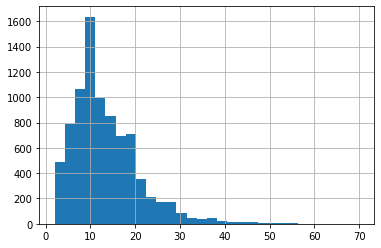

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 40

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = model.bert(sent_id, attention_mask=mask)['pooler_output']
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.06990881 0.93866667]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 100

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
 #     elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
for batch in train_dataloader:
  sentid, mask, label = [b.to(device) for b in batch]
  break
pre = model(sentid, mask)

In [ ]:
pre.shape, label.shape

(torch.Size([32, 2]), torch.Size([32]))

# Start Model Training


 Epoch 1 / 100
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.616
Validation Loss: 0.476

 Epoch 2 / 100
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.506
Validation Loss: 0.411

 Epoch 3 / 100
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.470
Validation Loss: 0.383

 Epoch 4 / 100
  Batch    50  of    264.
  Batch   100  of    264.
  Batch   150  of    264.
  Batch   200  of    264.
  Batch   250  of    264.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.435
Validation Loss: 0.624

 Epoch 5 / 100
  Batch    50  of    264.
  Batch   100  of    264.
  Ba

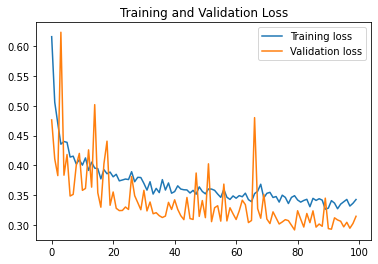

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

# Loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
'''with torch.no_grad():
  for i in range(len(test_seq) // 1000):
    temp = test_seq[i * 1000: (i + 1) * 1000]
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()'''

preds = []
for i in range(len(test_seq) // 1000 + 1):
  temp_seq = test_seq[i * 1000 : (i + 1) * 1000]
  temp_mask = test_mask[i * 1000 : (i + 1) * 1000]
  pred = model(temp_seq.to(device), temp_mask.to(device)).detach().cpu()
  preds.append(pred)
preds = torch.cat(preds, dim = 0).numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      7417
           1       0.92      0.88      0.90      9798

    accuracy                           0.89     17215
   macro avg       0.88      0.89      0.88     17215
weighted avg       0.89      0.89      0.89     17215



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,6681,736
1,1224,8574
